In [1]:
import os
import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from datetime import datetime
from multiprocessing import Manager
from PIL import Image

In [2]:
class CFG:
    batch_size = 16
    debug = False
    device = torch.device('cuda')
    dtype = torch.float32
    epochs = 18
    lr = 1e-4
    model_name = 'resnet_head'
    num_classes = 6
    nworkers = 1
    nfolds = 4
    n_tile = 11
    seed = 524
    TRAIN = '../yi_data/panda-16x128x128-tiles-data/train/'
    LABELS = '../data/train.csv'

# Split Data

In [10]:
train = pd.read_csv(CFG.LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(CFG.TRAIN)]))
train = train.loc[files].reset_index()

if CFG.debug:
    df = train.sample(n=50, random_state=CFG.seed).copy()
else:
    df = train.copy()

# Generate train/validation sets containing the same distribution of isup_grade
splits = StratifiedKFold(n_splits=CFG.nfolds, random_state=CFG.seed, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
# Assign split index to training samples
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(CFG.nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,2
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0


In [6]:
# https://www.kaggle.com/yasufuminakama/panda-se-resnext50-regression-baseline
class TrainDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, df, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.df = df
        self.labels = labels
        self.transform = transform
        #print(len(labels))
        class_counts = [len(labels[labels==g]) for g in range(CFG.num_classes)]
        self.num_samples = sum(class_counts)
        class_weights = [self.num_samples/class_counts[i] for i in range(len(class_counts))]
        self.weights = [class_weights[labels[i]] for i in range(self.num_samples)]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
        tile_fns = [f"{CFG.TRAIN}/{self.df['image_id'][idx]}_{sub_id}.png" for sub_id in range(CFG.n_tile)]
        img_tiles = [Image.fromarray(cv2.imread(fn)) for fn in tile_fns]
        if self.transform:
            img_tiles = list(map(self.transform, img_tiles))
        
        label = self.labels[idx]
        
        return (img_tiles, label)

## Transforms

In [7]:
def get_transforms(phase):
    assert phase in {'train', 'val'}
    
    if phase == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, fill=255),
            T.ToTensor(),
            T.Normalize( # mean&std based on 11 tiles
                mean=[0.8525, 0.7810, 0.8907],
                std=[0.1723, 0.2614, 0.1419],
            ),
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.8525, 0.7810, 0.8907],
                std=[0.1723, 0.2614, 0.1419],
            ),
        ])

In [6]:
"""
transform = get_transforms(phase='train')
train_dataset = TrainDataset(df.reset_index(drop=True),
                             df.reset_index(drop=True)['isup_grade'],
                             transform = get_transforms(phase='train'))
tiles, label = train_dataset[0]
#tiles = map(transform, tiles)
#print(list(tiles))
#print(label)
#print(tiles.shape)
#print(type(tiles[0]))
plt.imshow(tiles[1].permute(1,2,0))
#plt.show()
#plt.imshow(tiles[0].permute(1,2,0))
"""

"\ntransform = get_transforms(phase='train')\ntrain_dataset = TrainDataset(df.reset_index(drop=True),\n                             df.reset_index(drop=True)['isup_grade'],\n                             transform = get_transforms(phase='train'))\ntiles, label = train_dataset[0]\n#tiles = map(transform, tiles)\n#print(list(tiles))\n#print(label)\n#print(tiles.shape)\n#print(type(tiles[0]))\nplt.imshow(tiles[1].permute(1,2,0))\n#plt.show()\n#plt.imshow(tiles[0].permute(1,2,0))\n"

In [8]:
# Use fold idx as validation set
def data_loader(fold_idx):
    train_idx = df[df['split'] != fold_idx].index
    val_idx = df[df['split'] == fold_idx].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade'],
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade'],
                               transform = get_transforms(phase='val'))
    
    train_sampler = WeightedRandomSampler(weights=train_dataset.weights, num_samples=train_dataset.num_samples)
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler=train_sampler, num_workers=CFG.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.nworkers)
    return train_loader, val_loader

In [8]:
def train_model(model, fold, dataloaders, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    
    # Send the model to GPU/CPU
    model = model.to(device=CFG.device)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                model.eval()    # Set model to evaluate phase
            
            avg_loss = 0.0
            running_corrects = 0
            
            print(' ', end='', flush=True)  # To workaround tqdm issue in multiprocess
            for inputs, labels in tqdm(dataloaders[phase],
                                       desc='[{}] {}/{}({:5s})'.format(fold, epoch+1,num_epochs,phase)):
                _, C, H, W = inputs[0].shape
                # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
                inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
                labels = labels.to(device=CFG.device, dtype=torch.long)
                #print(labels)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    pred = torch.argmax(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                input_sz = inputs[0].shape[0]
                avg_loss += loss.item()*(input_sz/len(dataloaders[phase].dataset))  # len(dataloaders[phase].dataset) not len(dataloaders[phase])
                running_corrects += torch.sum(pred == labels)
            
            # End of epoch
            with torch.no_grad():
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                    # Apply lr_scheduler
                    if scheduler is not None:
                        scheduler.step(avg_loss)
                else:
                    train_acc_history.append(epoch_acc)
                    loss_history.append(avg_loss)
                print('[{}] {} Loss: {:4f} Acc: {:4f}'.format(fold, phase, avg_loss, epoch_acc))
    
    time_elapsed = time.time() - since
    print('[{}] Training complete in {:.0f}m {:0f}s'.format(fold, time_elapsed//60, time_elapsed%60))
    print('[{}] Best val Acc: {:4f}'.format(fold, best_acc))
    print()
    
    model.load_state_dict(best_model_wts)
                      
    return model, loss_history, train_acc_history, val_acc_history

## Layer Utils

In [3]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=1):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# https://www.kaggle.com/nelsongriffiths/mish-activation-and-transfer-learning-pytorch
def mish(x):
    return (x*torch.tanh(F.softplus(x)))

class mish_layer(nn.Module):
    def __init__(self):
        super(mish_layer, self).__init__()
        
    def forward(self, input):
        return mish(input)
    
class CustomResnet(nn.Module):
    def __init__(self, n=6):
        super().__init__()
        self.enc = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        num_ftrs= models.resnet18().fc.in_features
        self.head = nn.Sequential(
                        AdaptiveConcatPool2d(),
                        nn.Flatten(),
                        nn.Linear(num_ftrs*2,512),
                        mish_layer(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(0.5),
                        nn.Linear(512, n)
                    )
        
    def forward(self, x):
        n_tile = CFG.n_tile
        enc_out = self.enc(x)
        _, C, H, W = enc_out.shape
        # (bs,n_tile,512,4,4)-->(bs,512,n_tile,4,4)-->(bs,512,n_tile*4,4)
        head_in = enc_out.view(-1,n_tile,C,H,W).permute(0,2,1,3,4)\
                  .contiguous().view(-1,C,n_tile*H,W)
        head_out = self.head(head_in)
        
        return head_out

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False):
    """
    Params:
        feature_extract
            True - fine tunning
            False - fix the model
    """
    model_ft = None
    
    if model_name == 'alexnet':
        """AlexNet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet':
        """Resnet
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet_head':
        """Restnet with customized header
        """
        model_ft = CustomResnet(num_classes)
    
    return model_ft

In [11]:
"""
model_ft = initialize_model(CFG.model_name, CFG.num_classes, use_pretrained=False)
train_loader, _ = data_loader(0)
for tiles, _ in train_loader:
    print(tiles[0].shape)
    #plt.imshow(tiles[0].squeeze().permute(1,2,0))
    conv_out = model_ft(tiles)
    print(conv_out.shape)
    break
"""

'\nmodel_ft = initialize_model(CFG.model_name, CFG.num_classes, use_pretrained=False)\ntrain_loader, _ = data_loader(0)\nfor tiles, _ in train_loader:\n    print(tiles[0].shape)\n    #plt.imshow(tiles[0].squeeze().permute(1,2,0))\n    conv_out = model_ft(tiles)\n    print(conv_out.shape)\n    break\n'

In [12]:
"""Multiprocessing
"""
class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

def train_fn(fold):
    model_ft = initialize_model(CFG.model_name, CFG.num_classes, use_pretrained=True)
    """
    optimizer = optim.SGD(model_ft.parameters(),
                          lr=CFG.lr,
                          momentum=.9,
                          nesterov=True)
    """
    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    #print(f'### FOLD: {fold} ###', flush=True)
    loader_train, loader_val = data_loader(fold)
    best_model, loss_history, train_acc_history, val_acc_history = train_model(model_ft, fold, {'train': loader_train, 'val': loader_val}, F.cross_entropy, optimizer, scheduler, CFG.epochs)

    return best_model, loss_history, train_acc_history, val_acc_history

def progressor(fold):
    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)
    return {f'best_model_{fold}': best_model.to('cpu'),  # Don't save model as cuda
            f'loss_history_{fold}': loss_history,
            f'train_acc_history_{fold}': train_acc_history,
            f'val_acc_history_{fold}': val_acc_history}

## Resnet18
log: resnet_head_05_31_2020_00_08.pkl

In [13]:
log_dict = {'batch_size': CFG.batch_size,
            'epochs': CFG.epochs,
            'learning_rate': CFG.lr,
            'model': CFG.model_name,
            'nworkers': CFG.nworkers,
            'nfolds': CFG.nfolds,
            'random_seed': CFG.seed}

nfold = range(CFG.nfolds)
#nfold_left = range(CFG.nfolds//2)
#nfold_right = range(CFG.nfolds//2, CFG.nfolds)
#print(nfold_left)
#print(nfold_right)
#result_list = []
result_list = list(MyPool(CFG.nfolds).map(progressor, nfold))
#result_list.append(list(MyPool(CFG.nfolds).map(progressor, nfold_left)))
#result_list.append(list(MyPool(CFG.nfolds).map(progressor, nfold_right)))
#progressor(0)

# Accumulate result from each process
for result in result_list:
    log_dict.update(result)

# Log results
log_file = f'{CFG.model_name}_{datetime.now().strftime("%m_%d_%Y_%H_%M")}.pkl'
with open(log_file, 'wb') as pkl_file:
    pickle.dump(log_dict, pkl_file)


[0] train Loss: 0.345552 Acc: 0.235324
 


[0] val Loss: 0.303814 Acc: 0.356790
 


[3] train Loss: 0.340592 Acc: 0.258780
 


[2] train Loss: 0.343071 Acc: 0.248257
 


[1] train Loss: 0.346246 Acc: 0.230126
 


[2] val Loss: 0.301042 Acc: 0.354507
 


[3] val Loss: 0.301818 Acc: 0.343096
 


[1] val Loss: 0.311801 Acc: 0.297452
 


[0] train Loss: 0.318141 Acc: 0.304171
 


[0] val Loss: 0.294339 Acc: 0.367060
 


[2] train Loss: 0.320323 Acc: 0.302270
 


[3] train Loss: 0.322246 Acc: 0.297071
 


[1] train Loss: 0.320765 Acc: 0.297325
 


[3] val Loss: 0.293248 Acc: 0.356409
 


[2] val Loss: 0.310126 Acc: 0.365538
 


[1] val Loss: 0.280231 Acc: 0.370863
 


[0] train Loss: 0.305164 Acc: 0.326867
 


[0] val Loss: 0.302796 Acc: 0.358311
 


[3] train Loss: 0.306338 Acc: 0.321161
 


[2] train Loss: 0.305405 Acc: 0.327881
 


[1] train Loss: 0.308566 Acc: 0.324838
 


[3] val Loss: 0.306675 Acc: 0.330544
 


[1] val Loss: 0.276354 Acc: 0.406238
 


[2] val Loss: 0.278966 Acc: 0.401293
 


[0] train Loss: 0.295325 Acc: 0.341321
 


[0] val Loss: 0.267803 Acc: 0.421073
 


[3] train Loss: 0.295781 Acc: 0.344364
 


[1] train Loss: 0.298089 Acc: 0.345759
 


[2] train Loss: 0.298624 Acc: 0.345505
 


[3] val Loss: 0.282605 Acc: 0.413085
 


[1] val Loss: 0.287725 Acc: 0.369722
 


[2] val Loss: 0.263419 Acc: 0.415747
 


[0] train Loss: 0.291822 Acc: 0.355141
 


[0] val Loss: 0.339646 Acc: 0.279954
 


[3] train Loss: 0.288623 Acc: 0.362495
 


[1] train Loss: 0.290119 Acc: 0.353366
 


[2] train Loss: 0.289745 Acc: 0.361354
 


[3] val Loss: 0.269420 Acc: 0.415367
 


[1] val Loss: 0.276987 Acc: 0.405477
 


[2] val Loss: 0.285349 Acc: 0.354888
 


[0] train Loss: 0.286553 Acc: 0.377457
 


[0] val Loss: 0.288796 Acc: 0.372385
 


[3] train Loss: 0.283362 Acc: 0.372385
 


[1] train Loss: 0.284111 Acc: 0.366806
 


[2] train Loss: 0.283904 Acc: 0.377330
 


[3] val Loss: 0.259793 Acc: 0.440472
 


Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
[1] val Loss: 0.361848 Acc: 0.272347
 


[2] val Loss: 0.260682 Acc: 0.430582
 


[0] train Loss: 0.280211 Acc: 0.374160
 


Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
[0] val Loss: 0.365846 Acc: 0.251046
 


[3] train Loss: 0.276950 Acc: 0.386839
 


[2] train Loss: 0.281210 Acc: 0.378724
 


[1] train Loss: 0.272826 Acc: 0.392164
 


[3] val Loss: 0.274664 Acc: 0.402815
 


[2] val Loss: 0.269458 Acc: 0.429060
 


[1] val Loss: 0.250676 Acc: 0.459110
 


[0] train Loss: 0.269566 Acc: 0.405604
 


[0] val Loss: 0.257983 Acc: 0.443895
 


[3] train Loss: 0.276044 Acc: 0.392291
 


[2] train Loss: 0.277886 Acc: 0.381894
 


[1] train Loss: 0.270614 Acc: 0.400533
 


[0] train Loss: 0.266847 Acc: 0.419805
 


[3] val Loss: 0.258563 Acc: 0.442754
 


[2] val Loss: 0.453990 Acc: 0.204260
 


[1] val Loss: 0.255361 Acc: 0.448079
 


[0] val Loss: 0.244372 Acc: 0.465576
 


[0] train Loss: 0.265754 Acc: 0.427412
 


[3] train Loss: 0.274848 Acc: 0.399265
 


[2] train Loss: 0.274455 Acc: 0.393939
 


[1] train Loss: 0.267940 Acc: 0.402688
 


[0] val Loss: 0.247260 Acc: 0.457969
 


[3] val Loss: 0.270547 Acc: 0.430202
 


Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
[2] val Loss: 0.284952 Acc: 0.400152
 


[1] val Loss: 0.248237 Acc: 0.470901
 


[0] train Loss: 0.262906 Acc: 0.428807
 


[0] val Loss: 0.246659 Acc: 0.465576
 


[3] train Loss: 0.272362 Acc: 0.397870
 


[2] train Loss: 0.265389 Acc: 0.415747
 


[1] train Loss: 0.266262 Acc: 0.414226
 


[3] val Loss: 0.268551 Acc: 0.412324
 


[2] val Loss: 0.247766 Acc: 0.463294
 


[1] val Loss: 0.249980 Acc: 0.465196
 


[0] train Loss: 0.261718 Acc: 0.428300
 


Epoch    12: reducing learning rate of group 0 to 1.0000e-06.
[0] val Loss: 0.246721 Acc: 0.473564
 


[3] train Loss: 0.267510 Acc: 0.421833
 


[2] train Loss: 0.261249 Acc: 0.428300
 


[1] train Loss: 0.264576 Acc: 0.411563
 


[3] val Loss: 0.245839 Acc: 0.479270
 


[1] val Loss: 0.248370 Acc: 0.462533
 


[2] val Loss: 0.241229 Acc: 0.477748
 


[0] train Loss: 0.261368 Acc: 0.426271
 


[0] val Loss: 0.246162 Acc: 0.464816
 


[3] train Loss: 0.261698 Acc: 0.428300
 


[1] train Loss: 0.260816 Acc: 0.424750
 


[2] train Loss: 0.256043 Acc: 0.449474
 


[3] val Loss: 0.286398 Acc: 0.352225
 


Epoch    12: reducing learning rate of group 0 to 1.0000e-06.
[1] val Loss: 0.251869 Acc: 0.457208
 


[2] val Loss: 0.249821 Acc: 0.472803
 


[0] train Loss: 0.259594 Acc: 0.431216
 


[0] val Loss: 0.244428 Acc: 0.469760
 


[3] train Loss: 0.262948 Acc: 0.426778
 


[1] train Loss: 0.261752 Acc: 0.432103
 


[2] train Loss: 0.258920 Acc: 0.438570
 


[3] val Loss: 0.265321 Acc: 0.430582
 


[2] val Loss: 0.249086 Acc: 0.473944
 


[1] val Loss: 0.244955 Acc: 0.482693
 


[0] train Loss: 0.259625 Acc: 0.436414
 


[0] val Loss: 0.248960 Acc: 0.462914
 


[3] train Loss: 0.258673 Acc: 0.439077
 


[2] train Loss: 0.252604 Acc: 0.453404
 


[1] train Loss: 0.260633 Acc: 0.423735
 


Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
[3] val Loss: 0.268174 Acc: 0.411183
 


Epoch    14: reducing learning rate of group 0 to 1.0000e-06.
[2] val Loss: 0.244104 Acc: 0.478129
 


[1] val Loss: 0.244511 Acc: 0.470141
 


[0] train Loss: 0.257264 Acc: 0.438697
 


[0] val Loss: 0.242507 Acc: 0.479270
 


[3] train Loss: 0.248778 Acc: 0.466844
 


[2] train Loss: 0.251918 Acc: 0.462787
 


[1] train Loss: 0.260248 Acc: 0.421707
 


[3] val Loss: 0.236325 Acc: 0.495626
 


[2] val Loss: 0.240698 Acc: 0.486877
 


[1] val Loss: 0.250039 Acc: 0.466717
 


[0] train Loss: 0.260169 Acc: 0.432864
 


[0] val Loss: 0.241652 Acc: 0.476987
 


[3] train Loss: 0.243427 Acc: 0.481679
 


[2] train Loss: 0.253470 Acc: 0.452644
 


[1] train Loss: 0.260221 Acc: 0.435780
 


[3] val Loss: 0.236459 Acc: 0.493724
 


[2] val Loss: 0.237644 Acc: 0.495245
 


[1] val Loss: 0.244323 Acc: 0.475086
 


[0] train Loss: 0.261310 Acc: 0.431596
 


[0] val Loss: 0.241635 Acc: 0.479270
[0] Training complete in 386m 30.338371s
[0] Best val Acc: 0.479270


[3] train Loss: 0.237990 Acc: 0.492963
 


[2] train Loss: 0.253817 Acc: 0.449093
 


[1] train Loss: 0.257189 Acc: 0.440345
 


[3] val Loss: 0.234432 Acc: 0.504374
 


[2] val Loss: 0.238094 Acc: 0.498288
 


[1] val Loss: 0.245485 Acc: 0.473184
 


[3] train Loss: 0.237910 Acc: 0.490808
 


[2] train Loss: 0.248727 Acc: 0.456447
 


[1] train Loss: 0.255369 Acc: 0.439964
 


[3] val Loss: 0.233932 Acc: 0.498669
[3] Training complete in 418m 31.772800s
[3] Best val Acc: 0.504374


[2] val Loss: 0.237588 Acc: 0.492963
[2] Training complete in 418m 57.926975s
[2] Best val Acc: 0.498288


[1] val Loss: 0.245313 Acc: 0.478509
[1] Training complete in 419m 0.122100s
[1] Best val Acc: 0.482693



In [14]:
"""
for fold in range(CFG.nfolds):
    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)
    log_dict[f'best_model_{fold}'] = best_model
    log_dict[f'loss_history_{fold}'] = loss_history
    log_dict[f'train_acc_history_{fold}'] = train_acc_history
    log_dict[f'val_acc_history_{fold}'] = val_acc_history
"""

"\nfor fold in range(CFG.nfolds):\n    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)\n    log_dict[f'best_model_{fold}'] = best_model\n    log_dict[f'loss_history_{fold}'] = loss_history\n    log_dict[f'train_acc_history_{fold}'] = train_acc_history\n    log_dict[f'val_acc_history_{fold}'] = val_acc_history\n"

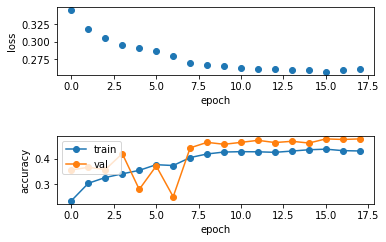

In [4]:
# read python dict back from the file
#with open(log_file, 'rb') as pfile:
with open('resnet_head_05_31_2020_00_08.pkl', 'rb') as pfile:
    test_dict = pickle.load(pfile)

"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(test_dict['loss_history_0'], 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(test_dict['train_acc_history_0'], '-o')
plt.plot(test_dict['val_acc_history_0'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.tight_layout(pad=3)
plt.show()

In [11]:
preds, targets = [], []
for fold in range(CFG.nfolds):
    model_fd = test_dict[f'best_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    #model_fd = log_dict[f'best_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    _, loader_val = data_loader(fold)
    for inputs, labels in tqdm(loader_val):
        _, C, H, W = inputs[0].shape
        # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
        inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
        labels = labels.to(device=CFG.device, dtype=torch.long)
                
        # Forward, track history if only in training
        with torch.no_grad():
            outputs = model_fd(inputs)
            pred = torch.argmax(outputs, 1)
        preds.append(pred)
        targets.append(labels)

Kappa: 0.6460268981665777


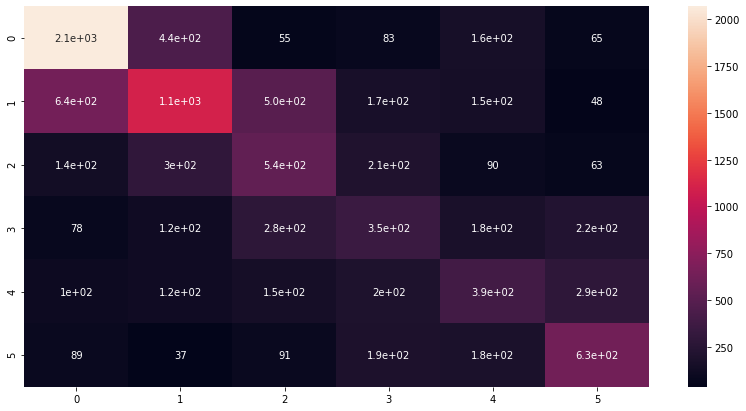

In [12]:
p = torch.cat(preds).cpu()
t = torch.cat(targets).cpu()
kappa = cohen_kappa_score(t, p, weights='quadratic')
print(f'Kappa: {kappa}')
conf_mat = confusion_matrix(t,p)
#plt.matshow()
plt.figure(figsize=(14,7))
sn.heatmap(conf_mat, annot=True)